In [213]:
import pandas as pd
from matplotlib import pyplot as pp
import numpy as np
from scipy.optimize import curve_fit
%matplotlib inline

# Constants

Some constants we'll use in other places.

In [214]:
R = 8.314e-3    # gas constant
T0 = 273.15     # convert celcius to K

# Data Munging

Load all of the data in and compute mean and standard deviation across temperature.

In [215]:
data = pd.read_excel('data.xlsx', names=['temp', 'wspr1', 'wspr2', 'wspr3', 'tdca1', 'tdca2', 'tdca3'])

In [216]:
data['wspr_mean'] = data[['wspr1', 'wspr2', 'wspr3']].mean(axis=1)
data['wspr_std'] = data[['wspr1', 'wspr2', 'wspr3']].std(axis=1)
data['tdca_mean'] = data[['tdca1', 'tdca2', 'tdca3']].mean(axis=1)
data['tdca_std'] = data[['tdca1', 'tdca2', 'tdca3']].std(axis=1)
data['temp'] = data['temp'] + T0

wspr_data = data[['temp', 'wspr_mean', 'wspr_std']].dropna()
wspr_data.columns = ['temp', 'mean', 'std']
tdca_data = data[['temp', 'tdca_mean', 'tdca_std']].dropna()
tdca_data.columns = ['temp', 'mean', 'std']

In [217]:
wspr_data

,temp,mean,std
0,298.15,0.004425,0.000581
1,302.15,0.005777,0.000013
2,304.15,0.007651,0.000469
3,306.15,0.007575,0.000135
4,308.15,0.008852,0.000396
5,310.15,0.010203,0.000570
6,312.15,0.004513,0.000808
8,314.15,0.000297,0.000131


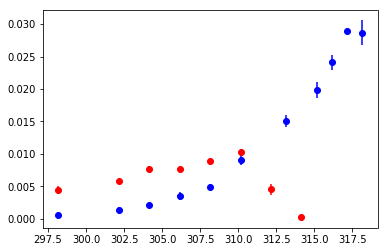

In [218]:
pp.errorbar(wspr_data['temp'], wspr_data['mean'], yerr=wspr_data['std'], linestyle='none', marker='o', color='red');
pp.errorbar(tdca_data['temp'], tdca_data['mean'], yerr=tdca_data['std'], linestyle='none', marker='o', color='blue');

# Drop Data

For WspR, we're going to drop the data over 310K, as the rate starts to drop

In [219]:
wspr_data = wspr_data[wspr_data['temp'] < 310]

# Models

## Arrhenius Model

Our first model is the Arrhenius equation:

\begin{equation}
r = A \exp\left[ \frac{-E_a}{RT}\right],
\end{equation}

where $E_a$ is the activation energy and $A$ is the pre-exponential factor.

In [220]:
def arrhenius(T, A, Ea):
    return A * np.exp(-Ea / R / T)

### WspR

In [221]:
wspr_arr_parm, wspr_arr_cov = curve_fit(arrhenius, xdata=wspr_data['temp'], ydata=wspr_data['mean'], 
                              sigma=wspr_data['std'], p0=[1e6, 50.0])

So, our fit $A=$

In [222]:
wspr_arr_parm[0]

10206527.623360757

and our fit $E_a=$

In [223]:
wspr_arr_parm[1]

53.488126099286887

### TdcA

In [224]:
tdca_arr_parm, tdca_arr_cov = curve_fit(arrhenius, xdata=tdca_data['temp'], ydata=tdca_data['mean'], 
                              sigma=tdca_data['std'], p0=[1e15, 150.0])

So, our fit $A=$

In [225]:
tdca_arr_parm[0]

1.8564242678186216e+24

and our fit $E_a=$

In [226]:
tdca_arr_parm[1]

156.69284558297679

### Summary

| Enzyme | $A$ | $E_a$ |
|--------|-----|-------|
| WspR   | 1e6 | 53.5  |
| TdcA   | 2e24| 156.7 |

The numbers for WspR seem reasonable, while TdcA values seem too high.

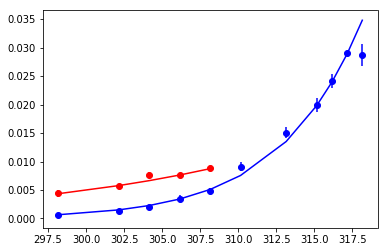

In [227]:
pp.errorbar(wspr_data['temp'], wspr_data['mean'], yerr=wspr_data['std'], linestyle='none', marker='o', color='red');
pp.plot(wspr_data['temp'], arrhenius(wspr_data['temp'], wspr_arr_parm[0], wspr_arr_parm[1]), color='red');

pp.errorbar(tdca_data['temp'], tdca_data['mean'], yerr=tdca_data['std'], linestyle='none', marker='o', color='blue');
pp.plot(tdca_data['temp'], arrhenius(tdca_data['temp'], tdca_arr_parm[0], tdca_arr_parm[1]), color='blue');

## Two State Model

In this model, we assume that there are two states, active and inactive, with a difference in enthalpy and entropy. We further assume that the reaction rate of the inactive state is zero and that of the active state is independent of temperature.

\begin{equation}
r = A f_{active},
\end{equation}

where

\begin{equation}
f_{active} = \frac{\exp \left[ \Delta S / R \right] \exp \left[-\Delta H / (RT) \right]}
                  {1 + \exp \left[ \Delta S / R \right] \exp \left[-\Delta H / (RT) \right] }
\end{equation}

In [234]:
def two_state(T, A, dH, dS):
    RT = R * T
    p_inactive = 1.0
    p_active = np.exp(dS / R) * np.exp(-dH / RT)
    return A * p_active / (p_inactive + p_active)

In [342]:
tdca_ts_parm, tdca_ts_cov = curve_fit(two_state, xdata=tdca_data['temp'], ydata=tdca_data['mean'], 
                                      sigma=tdca_data['std'], p0=[0.04, 200, 0.6], maxfev=10000)

This gives a reaction rate $A=$

In [343]:
tdca_ts_parm[0]

0.068289648432055011

and an enthalpy difference of $\Delta H=$

In [344]:
tdca_ts_parm[1]

195.28837433944915

in units of kJ/mol.

It gives an entropy difference of $\Delta S=$

In [345]:
tdca_ts_parm[2]

0.61309413832283166

in units of kJ / mol / K.

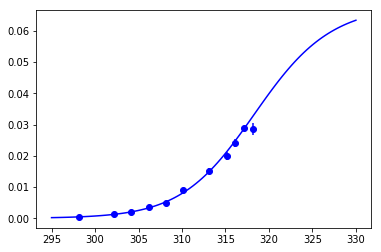

In [346]:
t = np.linspace(295, 330, 100)
pp.errorbar(tdca_data['temp'], tdca_data['mean'], yerr=tdca_data['std'], linestyle='none', marker='o', color='blue');
pp.plot(t, two_state(t, tdca_ts_parm[0], tdca_ts_parm[1], tdca_ts_parm[2]), color='blue');

## Summary

Overall, this fits quite well, but it appears like TdcA is only about half-active at the maximum temperature measured, which seems a bit odd.

## Two State + Arrhenius Model

For our final model, we combine the two.

\begin{equation}
r = f_{active} A \exp \left[ -E_a / (RT) \right],
\end{equation}

with $f_{active}$ defined as above.


In [347]:
def combined(T, A, Ea, dH, dS):
    RT = R * T
    r = A * np.exp(-Ea / RT)
    p_inactive = 1.0
    p_active = np.exp(dS / R) * np.exp(-dH / RT)
    return r * p_active / (p_inactive + p_active)

In [348]:
tdca_combined_parm, tdca_combined_cov = curve_fit(combined, xdata=tdca_data['temp'], ydata=tdca_data['mean'], 
                                                  p0=[0.07, 10, 200, 0.6], 
                                                  bounds=([0, 0, -250, -1], [1, 50, 250, 1]))

In [349]:
tdca_combined_parm

array([  4.91021429e-02,   5.66501727e-02,   2.08914548e+02,
         6.60773537e-01])

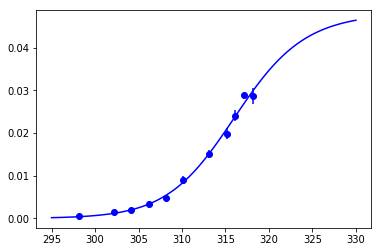

In [350]:
pp.errorbar(tdca_data['temp'], tdca_data['mean'], yerr=tdca_data['std'], linestyle='none', marker='o', color='blue');
pp.plot(t, combined(t, *tdca_combined_parm), color='blue')

## Summary

This model fits about as well as the two-state model.

The parameters are:

$A = 4.9e-2$

$E_a = 0.06 kJ / mol$

$\Delta H = 208.9 kJ / mol$

$\Delta S = 0.66 kJ / mol / K$


## Two-state + WspR Arrhenius

The last model will be the two-state model, but with the temperature dependence of WspR.

\begin{equation}
r = s \exp \left[-E_{a, WspR} / (RT) \right] f_{active}
\end{equation}

where $s$ is a scaling parameter.

In [351]:
def combined2(T, s, dH, dS):
    RT = R * T
    r = wspr_arr_parm[0] * np.exp(-wspr_arr_parm[1] / RT)
    p_inactive = 1.0
    p_active = np.exp(dS / R) * np.exp(-dH / RT)
    return s * r * p_active / (p_inactive + p_active)

In [354]:
tdca_combined2_parm, tdca_2combined_cov = curve_fit(combined2, xdata=tdca_data['temp'], ydata=tdca_data['mean'], 
                                                    p0=[1, 200, 0.6])

In [355]:
tdca_combined2_parm

array([   2.21314584,  192.10910737,    0.61570768])

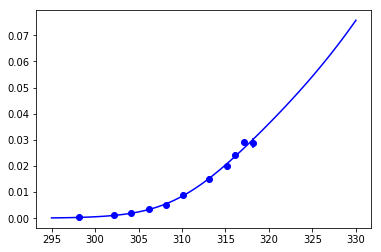

In [357]:
pp.errorbar(tdca_data['temp'], tdca_data['mean'], yerr=tdca_data['std'], linestyle='none', marker='o', color='blue');
pp.plot(t, combined2(t, *tdca_combined2_parm), color='blue')

### Summary

This fits about as well as everything else, with

$\Delta H = 192.1 kJ / mol$

$\Delta S = 0.61 kJ / mol / K$

# Overall Summary

All of the models fit the available data relative well. It would be very useful to get more data at slightly higher temperatures, as the various two-state models predict a plateau, while the Arrhenius model will keep increasing. Of course, this is highly dependent on the ability to carry out the assay at such higher temperatures.

The two-state model predicts a characteristic DSC curve, so DSC may provide evidence for or against this model.

Overall, the activation energies and pre-exponential factors seem too high for Arrhenius fits of TdcA. The enthalpy and entropy differences are also large for the two-state models, but these might make sense for some sort of conformational change. In either case, the T-dependence of TdcA is quite unique.